## Dudas


*   Se pueden meter capas adicionales al modelo congelado (FC, conv...) y entrenar estas capas como opción?


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/eyes.zip" -d "/content/eyes"

In [1]:
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, AveragePooling2D
from keras.layers import BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet201
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


import pandas as pd
from glob import glob
import cv2
from tqdm import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-c8efqudq because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [11]:
# Constantes para el resto del programa
image_size = 64
channels = 3
seed = 1
test_size = 0.2

batch_size = 16
epochs = 5
validation_split = 0.1

In [12]:
def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    pyplot.plot(loss)
    pyplot.plot(val_loss)
    pyplot.legend(['Training loss', 'Validation loss'])
    pyplot.show()
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    pyplot.plot(acc)
    pyplot.plot(val_acc)
    pyplot.legend(['Training accuracy','Validation accuracy'])
    pyplot.show()

In [13]:
label = 0
df = pd.DataFrame()
for file in glob('./eyes/*'):
    print ('Etiquetando las imágenes de '+ file)
    for images in tqdm(glob(file + '/*')):
        image = cv2.imread(images)
        image = cv2.resize(image,(image_size,image_size))
        data = pd.DataFrame({'image':[image],'label':[label]})
        df = df.append(data)
    print('Fin del etiquetado de la carpeta.')

    label = 1

Etiquetando las imágenes de ./eyes/femaleeyes


100%|██████████| 5202/5202 [00:03<00:00, 1621.86it/s]


Fin del etiquetado de la carpeta.
Etiquetando las imágenes de ./eyes/maleeyes


100%|██████████| 6323/6323 [00:04<00:00, 1521.64it/s]

Fin del etiquetado de la carpeta.


In [14]:
train_data, test_data = train_test_split(df, test_size = test_size, random_state = seed)

In [15]:
def transformar_a_tensor(datos):
    datos = np.reshape(datos.to_list(),(len(datos),image_size,image_size,channels))
#    datos = datos/255.0
    return datos

x_train = transformar_a_tensor(train_data.image)
x_test = transformar_a_tensor(test_data.image)
y_train = np.array(train_data.label.values)
y_test = np.array(test_data.label.values)

In [16]:
def preprocesar_datos_densenet(x_train, y_train, x_test, y_test):
  return preprocess_input(x_train), to_categorical(y_train), preprocess_input(x_test), to_categorical(y_test)

In [17]:
x_train, y_train, x_test, y_test = preprocesar_datos_densenet(x_train, y_train, x_test, y_test)

In [18]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(9220, 64, 64, 3)
(2305, 64, 64, 3)
(9220, 2)
(2305, 2)


In [ ]:
def model_frozen_only_classifier(batch_size, epochs):

  densenet = DenseNet201(
    input_shape=(image_size, image_size, channels),
    include_top = False,
    weights="imagenet",
    pooling="avg"
  )
  for layer in densenet.layers[:]:
    layer.trainable = False

  model = Sequential()
  model.add(densenet)
  model.add(Dense(2, activation="softmax"))
  model.summary()

  model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
  )
  
  hist = model.fit(x_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs,
                  verbose = 1,
                  validation_split = 0.1)

  mostrarEvolucion(hist)

  print('RESULTADOS EN TEST:')
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Pérdida en test:', score[0])
  print('Accuracy en test:', score[1])

  del model, score, hist, densenet

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_15 (Dense)            (None, 2)                 3842      
                                                                 
Total params: 18,325,826
Trainable params: 3,842
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/10
260/260 [==============================] - 37s 98ms/step - loss: 0.6907 - accuracy: 0.5536 - val_loss: 0.6962 - val_accuracy: 0.5260
Epoch 2/10
260/260 [==============================] - 22s 84ms/step - loss: 0.6564 - accuracy: 0.6189 - val_loss: 0.6440 - val_accuracy: 0.6703
Epoch 3/10
260/260 [==============================] - 23s 87ms/step - loss: 0.6398 - accuracy: 0.6393 - val_loss: 0.6285 - val_accuracy: 0.6768
Ep

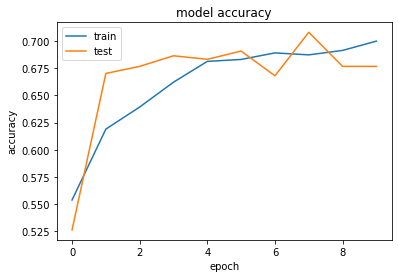

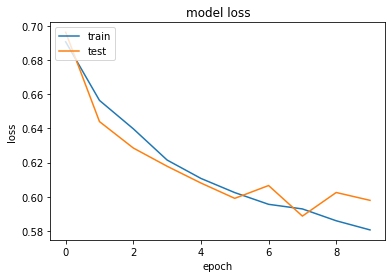

RESULTADOS EN TEST:
Pérdida en test: 0.5912051200866699
Accuracy en test: 0.6694143414497375


In [ ]:
model_frozen_only_classifier(64, 10)

In [ ]:
def model_frozen_classifier_FC_128(batch_size, epochs):

  densenet = DenseNet201(
    input_shape=(image_size, image_size, channels),
    include_top = False,
    weights="imagenet",
    pooling="avg"
  )
  for layer in densenet.layers[:]:
    layer.trainable = False

  model = Sequential()
  model.add(densenet)
  model.add(Dense(128, activation='relu'))
  model.add(Dense(2, activation="softmax"))
  model.summary()

  model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
  )
  
  hist = model.fit(x_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs,
                  verbose = 1,
                  validation_split = 0.1)
  
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  print('RESULTADOS EN TEST:')
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Pérdida en test:', score[0])
  print('Accuracy en test:', score[1])

  del model, score, hist, densenet

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_9 (Dense)             (None, 128)               245888    
                                                                 
 dense_10 (Dense)            (None, 2)                 258       
                                                                 
Total params: 18,568,130
Trainable params: 246,146
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/25
130/130 [==============================] - 29s 134ms/step - loss: 0.6708 - accuracy: 0.5951 - val_loss: 0.6387 - val_accuracy: 0.6822
Epoch 2/25
130/130 [==============================] - 14s 107ms/step - loss: 0.6339 - accuracy: 0.6511 - val_loss: 0.6066 - val_accuracy: 0.6952
Epoch 3/25

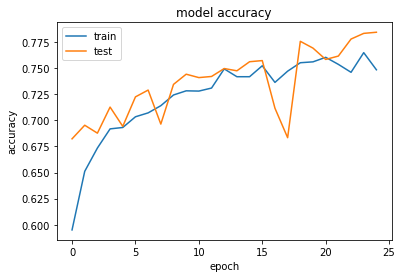

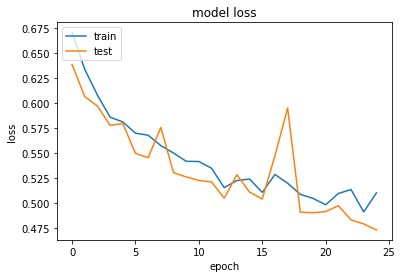

RESULTADOS EN TEST:
Pérdida en test: 0.481204092502594
Accuracy en test: 0.7713665962219238


In [ ]:
model_frozen_classifier_FC_128(64, 25)

In [ ]:
def model_frozen_classifier_FC_128_dropout(batch_size, epochs):

  densenet = DenseNet201(
    input_shape=(image_size, image_size, channels),
    include_top = False,
    weights="imagenet",
    pooling="avg"
  )
  for layer in densenet.layers[:]:
    layer.trainable = False

  model = Sequential()
  model.add(densenet)
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation="softmax"))
  model.summary()

  model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(1e-3),
    metrics=["accuracy"]
  )
  
  hist = model.fit(x_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs,
                  verbose = 1,
                  validation_split = 0.1)
  
  mostrarEvolucion(hist)

  print('RESULTADOS EN TEST:')
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Pérdida en test:', score[0])
  print('Accuracy en test:', score[1])

  del model, score, hist, densenet

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_3 (Dense)             (None, 128)               245888    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 258       
                                                                 
Total params: 18,568,130
Trainable params: 246,146
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/25
130/130 [==============================] - 29s 134ms/step - loss: 0.6925 - accuracy: 0.5542 - val_loss: 0.6718 - val_accuracy: 0.5531
Epoch 2/25
130/130 [===

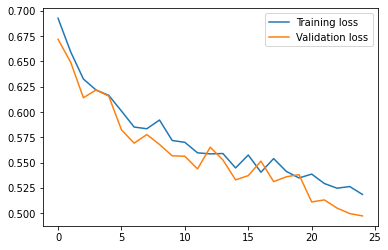

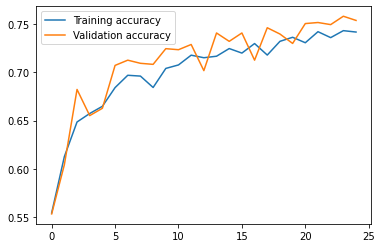

RESULTADOS EN TEST:
Pérdida en test: 0.4989694654941559
Accuracy en test: 0.7561821937561035


In [ ]:
model_frozen_classifier_FC_128_dropout(64,25)

In [ ]:
def model_frozen_classifier_FC_256(batch_size, epochs):

  densenet = DenseNet201(
    input_shape=(image_size, image_size, channels),
    include_top = False,
    weights="imagenet",
    pooling="avg"
  )
  for layer in densenet.layers[:]:
    layer.trainable = False

  model = Sequential()
  model.add(densenet)
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(2, activation="softmax"))
  model.summary()

  model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(1e-3),
    metrics=["accuracy"]
  )
  
  hist = model.fit(x_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs,
                  verbose = 1,
                  validation_split = 0.1)
  
  mostrarEvolucion(hist)

  print('RESULTADOS EN TEST:')
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Pérdida en test:', score[0])
  print('Accuracy en test:', score[1])

  del model, score, hist, densenet

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_6 (Dense)             (None, 256)               491776    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 2)                 258       
                                                                 
Total params: 18,846,914
Trainable params: 524,930
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/25
130/130 [==============================] - 30s 136ms/step - loss: 0.6831 - accuracy: 0.5654 - val_loss: 0.6546 - val_accuracy: 0.6692
Epoch 2/25
130/130 [===

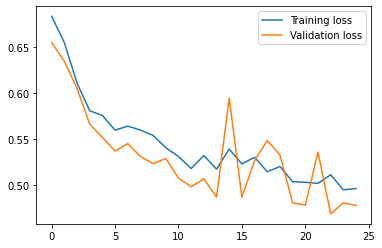

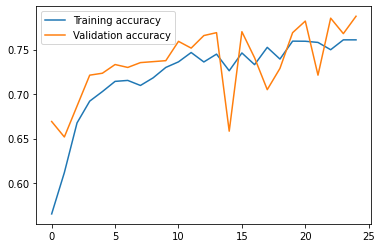

RESULTADOS EN TEST:
Pérdida en test: 0.48511388897895813
Accuracy en test: 0.7813448905944824


In [ ]:
model_frozen_classifier_FC_256(64,25)

In [ ]:
def model_defrost_conv5_only_classifier(batch_size, epochs_frozen, epochs_defrost):

  densenet = DenseNet201(
    input_shape=(image_size, image_size, channels),
    include_top = False,
    weights="imagenet",
    pooling="avg"
  )

  for layer in densenet.layers:
    layer.trainable = False

  model = Sequential()
  model.add(densenet)
  model.add(Dense(2, activation="softmax"))
  model.summary()

  model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
  )
  
  hist = model.fit(x_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs_frozen,
                  verbose = 1,
                  validation_split = 0.1)

  mostrarEvolucion(hist)

  print('RESULTADOS EN TEST:')
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Pérdida en test:', score[0])
  print('Accuracy en test:', score[1])

  del score, hist

  for layer in densenet.layers:
    if 'conv5' in layer.name:
      layer.trainable = True
    else:
      layer.trainable = False

  model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]
  )

  model.summary()
    
  hist = model.fit(x_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs_defrost,
                  verbose = 1,
                  validation_split = 0.1)

  mostrarEvolucion(hist)

  print('RESULTADOS EN TEST:')
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Pérdida en test:', score[0])
  print('Accuracy en test:', score[1])


  del model, score, hist, densenet


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_1 (Dense)             (None, 2)                 3842      
                                                                 
Total params: 18,325,826
Trainable params: 3,842
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/10
260/260 [==============================] - 42s 103ms/step - loss: 0.6776 - accuracy: 0.5746 - val_loss: 0.6601 - val_accuracy: 0.6139
Epoch 2/10
260/260 [==============================] - 22s 84ms/step - loss: 0.6496 - accuracy: 0.6297 - val_loss: 0.6536 - val_accuracy: 0.6106
Epoch 3/10
260/260 [==============================] - 22s 84ms/step - loss: 0.6322 - accuracy: 0.6532 - val_loss: 0.6320 - val_accuracy: 0.6649
E

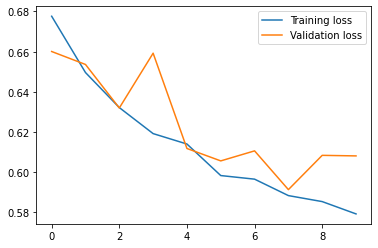

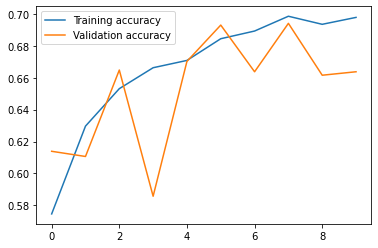

RESULTADOS EN TEST:
Pérdida en test: 0.5998250246047974
Accuracy en test: 0.6607375144958496
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_1 (Dense)             (None, 2)                 3842      
                                                                 
Total params: 18,325,826
Trainable params: 6,982,402
Non-trainable params: 11,343,424
_________________________________________________________________
Epoch 1/20
260/260 [==============================] - 52s 131ms/step - loss: 0.5954 - accuracy: 0.7079 - val_loss: 1.1601 - val_accuracy: 0.4794
Epoch 2/20
260/260 [==============================] - 31s 118ms/step - loss: 0.4718 - accuracy: 0.7775 - val_loss: 0.4739 - val_accuracy: 0.7842
Epoch 3/20
260/260 [===========================

KeyboardInterrupt: ignored

In [ ]:
model_defrost_conv5_only_classifier(64,10,20)

In [ ]:
def model_defrost_conv5_only_classifier_max(batch_size, epochs_frozen, epochs_defrost):

  densenet = DenseNet201(
    input_shape=(image_size, image_size, channels),
    include_top = False,
    weights="imagenet",
    pooling="max"
  )

  for layer in densenet.layers:
    layer.trainable = False

  model = Sequential()
  model.add(densenet)
  model.add(Dense(2, activation="softmax"))
  model.summary()

  model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
  )
  
  hist = model.fit(x_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs_frozen,
                  verbose = 1,
                  validation_split = 0.1)

  mostrarEvolucion(hist)

  print('RESULTADOS EN TEST:')
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Pérdida en test:', score[0])
  print('Accuracy en test:', score[1])

  del score, hist

  for layer in densenet.layers:
    if 'conv5' in layer.name:
      layer.trainable = True
    else:
      layer.trainable = False

  model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]
  )

  model.summary()
    
  hist = model.fit(x_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs_defrost,
                  verbose = 1,
                  validation_split = 0.1)

  mostrarEvolucion(hist)

  print('RESULTADOS EN TEST:')
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Pérdida en test:', score[0])
  print('Accuracy en test:', score[1])


  del model, score, hist, densenet


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_6 (Dense)             (None, 2)                 3842      
                                                                 
Total params: 18,325,826
Trainable params: 3,842
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/10
130/130 [==============================] - 29s 134ms/step - loss: 0.6937 - accuracy: 0.5483 - val_loss: 0.6917 - val_accuracy: 0.5260
Epoch 2/10
130/130 [==============================] - 14s 107ms/step - loss: 0.6617 - accuracy: 0.6132 - val_loss: 0.6570 - val_accuracy: 0.6150
Epoch 3/10
130/130 [==============================] - 14s 106ms/step - loss: 0.6512 - accuracy: 0.6275 - val_loss: 0.6426 - val_accuracy: 0.6562

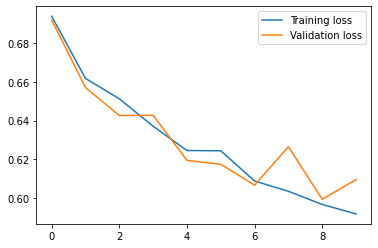

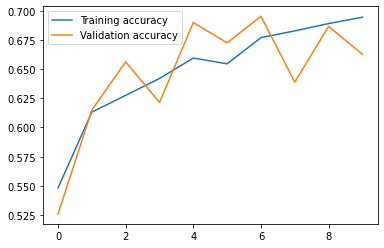

RESULTADOS EN TEST:
Pérdida en test: 0.6003801226615906
Accuracy en test: 0.6624729037284851
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_6 (Dense)             (None, 2)                 3842      
                                                                 
Total params: 18,325,826
Trainable params: 6,982,402
Non-trainable params: 11,343,424
_________________________________________________________________
Epoch 1/20
130/130 [==============================] - 38s 169ms/step - loss: 0.5979 - accuracy: 0.6975 - val_loss: 1.1503 - val_accuracy: 0.4740
Epoch 2/20
130/130 [==============================] - 20s 152ms/step - loss: 0.4773 - accuracy: 0.7731 - val_loss: 1.3635 - val_accuracy: 0.4740
Epoch 3/20
130/130 [===========================

KeyboardInterrupt: ignored

In [ ]:
model_defrost_conv5_only_classifier_max(64,10,20)

In [ ]:
 def model_defrost_conv5_data_augmentation(batch_size, epochs_frozen, epochs_defrost):

  train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    rotation_range=20,
    #zoom_range=0.2,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #fill_mode="nearest",
    validation_split = validation_split)

  valid_datagen = ImageDataGenerator(validation_split=validation_split)

  train_generator = train_datagen.flow(x_train, y_train, batch_size = batch_size, subset='training', shuffle=True)
  validation_generator = valid_datagen.flow(x_train, y_train, batch_size = batch_size, subset='validation', shuffle=True)

  densenet = DenseNet201(
    input_shape=(image_size, image_size, channels),
    include_top = False,
    weights="imagenet",
    pooling="avg"
  )

  for layer in densenet.layers:
    layer.trainable = False

  model = Sequential()

  model.add(densenet)

  model.add(Dense(2, activation="softmax"))
  model.summary()

  model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
  )
  
  hist = model.fit(train_generator,
                  validation_data=validation_generator,
                  batch_size = batch_size,
                  epochs = epochs_frozen,
                  verbose = 1
                  )
  
  mostrarEvolucion(hist)

  print('RESULTADOS EN TEST:')
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Pérdida en test:', score[0])
  print('Accuracy en test:', score[1])

  del score, hist

  for layer in densenet.layers:
    if 'conv5' in layer.name:
      layer.trainable = True
    else:
      layer.trainable = False

  model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(2e-5),
    metrics=["accuracy"]
  )

  model.summary()
    
  hist = model.fit(train_generator,
                  validation_data=validation_generator,
                  batch_size = batch_size,
                  epochs = epochs_defrost,
                  verbose = 1
                  )
  
  mostrarEvolucion(hist)


  print('RESULTADOS EN TEST:')
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Pérdida en test:', score[0])
  print('Accuracy en test:', score[1])


  del model, score, hist, densenet


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_5 (Dense)             (None, 2)                 3842      
                                                                 
Total params: 18,325,826
Trainable params: 3,842
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/15
130/130 [==============================] - 35s 161ms/step - loss: 0.6953 - accuracy: 0.5403 - val_loss: 0.6715 - val_accuracy: 0.6193
Epoch 2/15
130/130 [==============================] - 17s 133ms/step - loss: 0.6698 - accuracy: 0.5882 - val_loss: 0.6626 - val_accuracy: 0.6562
Epoch 3/15
130/130 [==============================] - 17s 132ms/step - loss: 0.6572 - accuracy: 0.6175 - val_loss: 0.6439 - val_accuracy: 0.6367

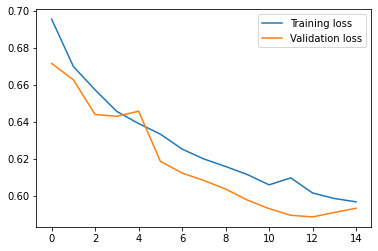

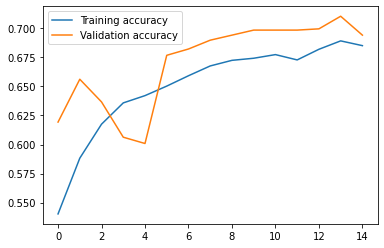

RESULTADOS EN TEST:
Pérdida en test: 0.5978305339813232
Accuracy en test: 0.7023861408233643
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_5 (Dense)             (None, 2)                 3842      
                                                                 
Total params: 18,325,826
Trainable params: 6,982,402
Non-trainable params: 11,343,424
_________________________________________________________________
Epoch 1/30
130/130 [==============================] - 40s 189ms/step - loss: 0.6277 - accuracy: 0.6834 - val_loss: 0.8309 - val_accuracy: 0.4534
Epoch 2/30
130/130 [==============================] - 21s 159ms/step - loss: 0.5209 - accuracy: 0.7458 - val_loss: 1.5267 - val_accuracy: 0.4501
Epoch 3/30
130/130 [===========================

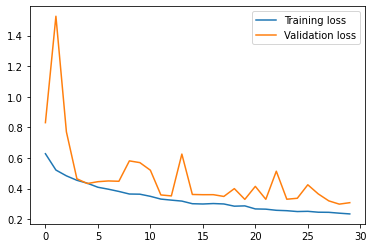

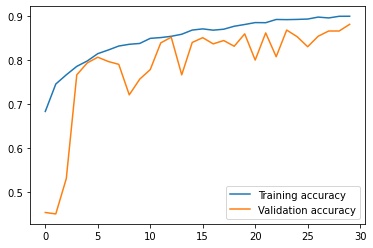

RESULTADOS EN TEST:
Pérdida en test: 0.26944565773010254
Accuracy en test: 0.8963123559951782


In [ ]:
model_defrost_conv5_data_augmentation(64,15,30)

In [19]:
def model_defrost_conv5_data_augmentation_with_FC(batch_size, epochs_frozen, epochs_defrost):

  train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    rotation_range=20,
    #zoom_range=0.2,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #fill_mode="nearest",
    validation_split = validation_split)

  valid_datagen = ImageDataGenerator(validation_split=validation_split)

  train_generator = train_datagen.flow(x_train, y_train, batch_size = batch_size, subset='training', shuffle=True)
  validation_generator = valid_datagen.flow(x_train, y_train, batch_size = batch_size, subset='validation', shuffle=True)

  densenet = DenseNet201(
    input_shape=(image_size, image_size, channels),
    include_top = False,
    weights="imagenet",
    pooling="avg"
  )

  for layer in densenet.layers:
    layer.trainable = False

  model = Sequential()

  model.add(densenet)

  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.5))

  model.add(Dense(2, activation="softmax"))
  model.summary()

  model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
  )
  
  hist = model.fit(train_generator,
                  validation_data=validation_generator,
                  batch_size = batch_size,
                  epochs = epochs_frozen,
                  verbose = 1
                  )
  
  mostrarEvolucion(hist)

  print('RESULTADOS EN TEST:')
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Pérdida en test:', score[0])
  print('Accuracy en test:', score[1])

  del score, hist

  for layer in densenet.layers:
    if 'conv5' in layer.name:
      layer.trainable = True
    else:
      layer.trainable = False

  model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(2e-5),
    metrics=["accuracy"]
  )

  model.summary()
    
  hist = model.fit(train_generator,
                  validation_data=validation_generator,
                  batch_size = batch_size,
                  epochs = epochs_defrost,
                  verbose = 1
                  )
  
  mostrarEvolucion(hist)


  print('RESULTADOS EN TEST:')
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Pérdida en test:', score[0])
  print('Accuracy en test:', score[1])


  del model, score, hist, densenet


74850304/74836368 [==============================] - 8s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 18,568,130
Trainable params: 246,146
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/15
130/130 [==============================] - 22s 104ms/step - loss: 0.4835 - accuracy: 0.7924 - 

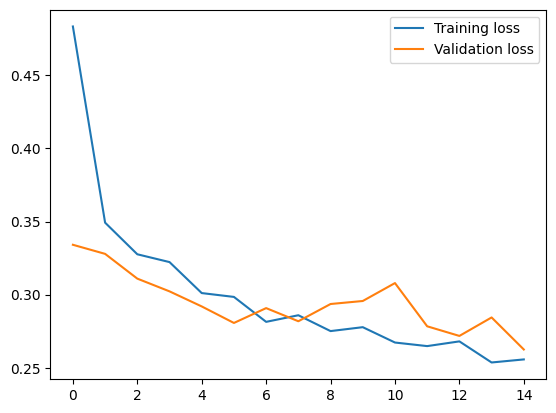

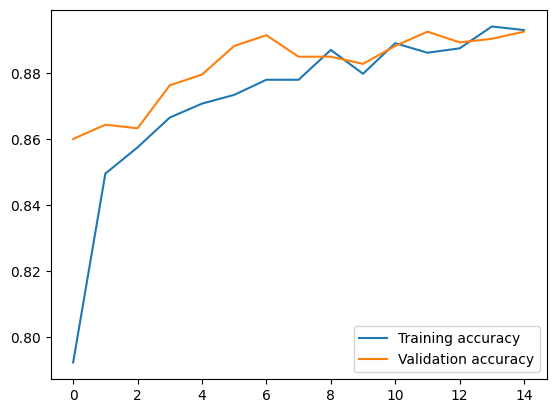

RESULTADOS EN TEST:
Pérdida en test: 0.23467867076396942
Accuracy en test: 0.898481547832489
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 18,568,130
Trainable params: 7,224,706
Non-trainable params: 11,343,424
_________________________________________________________________
Epoch 1/30
130/130 [==============================] - 23s 108ms/step - loss

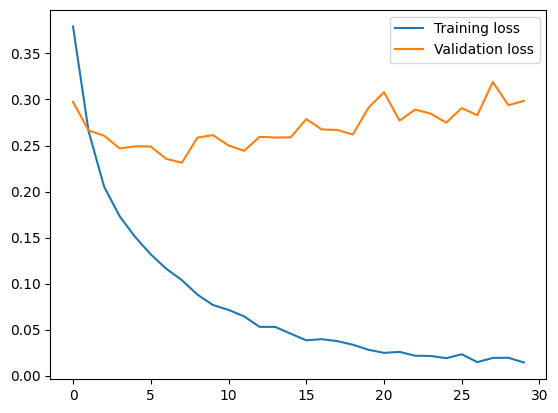

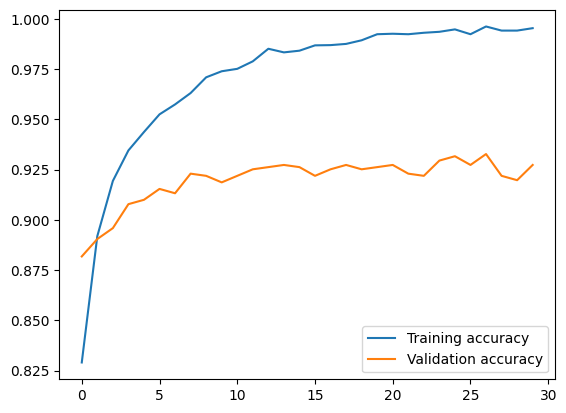

RESULTADOS EN TEST:
Pérdida en test: 0.21844536066055298
Accuracy en test: 0.9401301741600037


In [20]:
model_defrost_conv5_data_augmentation_with_FC(64,15,30)